Configuration & Path Setup

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")


Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


In [13]:
# 2. Import Custom Modules

from src.data_loader_tx import ClinicalTrialLoader
from src.preprocessing_XGB_ND import get_pipeline

 Smart Data Loading (Auto-Generation)

In [14]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (67363, 136)


Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [15]:
# ----------------------------------------------------------------------------------
# TEMPORAL SPLIT & STATISTICS REPORT
# ----------------------------------------------------------------------------------

# 1. Sort by Date to ensure we predict the future from the past
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (e.g., 70% Train, 20% Test)
split_idx = int(len(df) * 0.70)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 3. Define Features & Target

target_col = 'target'

drop_cols = [target_col, 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

X_train = train_df.drop(columns=drop_cols, errors='ignore')
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols, errors='ignore')
y_test = test_df[target_col]

# ----------------------------------------------------------------------------------
# PRINT STATISTICS
# ----------------------------------------------------------------------------------
def print_stats(name, dataset, y):
    n_total = len(dataset)
    n_good = len(dataset[y == 0]) # 0 = Completed
    n_bad = len(dataset[y == 1])  # 1 = Terminated/Withdrawn

    pct_good = (n_good / n_total) * 100
    pct_bad = (n_bad / n_total) * 100

    min_year = dataset['start_year'].min()
    max_year = dataset['start_year'].max()

    print(f"--- {name} SET ---")
    print(f"Time Period:   {int(min_year)} to {int(max_year)}")
    print(f"Total Trials:  {n_total}")
    print(f"Good (0):      {n_good} ({pct_good:.1f}%)")
    print(f"Bad (1):       {n_bad} ({pct_bad:.1f}%)")
    print("")

print("="*40)
print("DATASET SPLIT STATISTICS")
print("="*40)

# Overall
print_stats("OVERALL", df, df[target_col])

# Training
print_stats("TRAINING (Past)", train_df, y_train)

# Testing
print_stats("TESTING (Future)", test_df, y_test)

print("="*40)
print(f"Split Ratio: {len(train_df)/len(df):.0%} Train / {len(test_df)/len(df):.0%} Test")

DATASET SPLIT STATISTICS
--- OVERALL SET ---
Time Period:   2000 to 2015
Total Trials:  67363
Good (0):      56414 (83.7%)
Bad (1):       10949 (16.3%)

--- TRAINING (Past) SET ---
Time Period:   2000 to 2012
Total Trials:  47154
Good (0):      39858 (84.5%)
Bad (1):       7296 (15.5%)

--- TESTING (Future) SET ---
Time Period:   2012 to 2015
Total Trials:  20209
Good (0):      16556 (81.9%)
Bad (1):       3653 (18.1%)

Split Ratio: 70% Train / 30% Test


Model training

In [21]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# Cell 12: The "0.36 Precision" Configuration

# 1. Weights
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_weight = neg_count / pos_count  # Full Ratio

# 2. Model
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', XGBClassifier(
        n_estimators=1500,
        learning_rate=0.015,
        max_depth=8,             # Deep trees for embeddings
        min_child_weight=5,
        gamma=0.5,               # Low pruning
        subsample=0.8,
        colsample_bytree=0.4,    # Feature diversity
        scale_pos_weight=scale_weight,
        reg_alpha=1,
        reg_lambda=5,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])
# 3. Train
print(f"Training Deep XGBoost on {len(X_train)} trials...")
model.fit(X_train, y_train)
print("Training Complete.")

Training Deep XGBoost on 47154 trials...


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(


Training Complete.


Evaluation & Visualization

/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.6733  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3025   (Baseline: 0.1808)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     16556
           1       0.36      0.28      0.31      3653

    accuracy                           0.78     20209
   macro avg       0.60      0.58      0.59     20209
weighted avg       0.76      0.78      0.77     20209



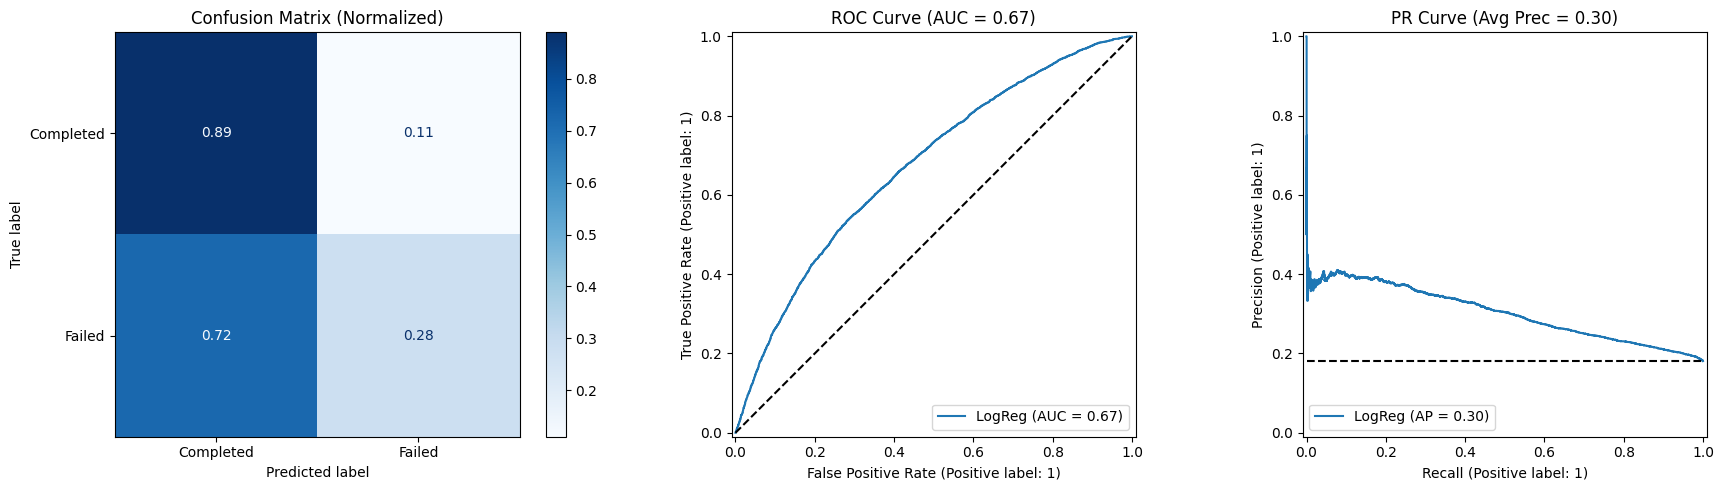

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

# 3. Business Rule (Custom Threshold)
# We lower the threshold to catch more failures (High Recall strategy)

#threshold = 0.4
#y_pred_custom = (y_prob >= threshold).astype(int)
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()

#recall = tp / (tp + fn)
#precision = tp / (tp + fp)


# 3. Visualizations
#fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
#ConfusionMatrixDisplay.from_predictions(
#    y_test, y_pred,
#    normalize='true',
#    cmap='Blues',
#    display_labels=['Completed', 'Failed'],
#    ax=ax[0]
#)
#ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
#RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
#ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
#ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

## C. Precision-Recall Curve
#PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
#ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
#ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

#plt.tight_layout()
#plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_recall_curve

# 1. Get Probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# 2. Find Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score:  {f1_scores[best_idx]:.4f}")

# 3. Apply New Threshold
y_pred_new = (y_probs >= best_threshold).astype(int)

print("\n--- OPTIMIZED CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_new))

/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best Threshold: 0.2932
Best F1 Score:  0.3809

--- OPTIMIZED CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.88      0.72      0.79     16556
           1       0.30      0.53      0.38      3653

    accuracy                           0.69     20209
   macro avg       0.59      0.63      0.59     20209
weighted avg       0.77      0.69      0.72     20209



In [20]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# 1. Define the Search Space
# This tells the computer: "Try values between these ranges"
param_dist = {
    'classifier__n_estimators': randint(500, 1500),
    'classifier__learning_rate': uniform(0.01, 0.1),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__gamma': uniform(0, 5),
    'classifier__subsample': uniform(0.5, 0.4),       # 0.5 to 0.9
    'classifier__colsample_bytree': uniform(0.4, 0.5),# 0.4 to 0.9
    'classifier__scale_pos_weight': uniform(1, 10)    # Try different weights
}

# 2. Setup the Pipeline
# We pass the preprocessor we defined earlier
model_pipeline = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_jobs=-1,
        random_state=42
    ))
])

# 3. Setup Time-Series Validation
# This ensures we don't cheat by training on 2015 and testing on 2014
tscv = TimeSeriesSplit(n_splits=3)

# 4. Configure the Search
search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=15,           # Run 15 different random experiments
    scoring='roc_auc',   # Optimize for AUC
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 5. Run the Search (This will take ~5-10 mins)
print("Running Automated Hyperparameter Tuning...")
search.fit(X_train, y_train)

print("\n✅ BEST PARAMETERS FOUND:")
print(search.best_params_)
print(f"Best Validation AUC: {search.best_score_:.4f}")

# 6. Save the best model to use later
model = search.best_estimator_

Running Automated Hyperparameter Tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/


✅ BEST PARAMETERS FOUND:
{'classifier__colsample_bytree': np.float64(0.4127095633720476), 'classifier__gamma': np.float64(0.5394571349665223), 'classifier__learning_rate': np.float64(0.013142918568673426), 'classifier__max_depth': 9, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 1063, 'classifier__scale_pos_weight': np.float64(6.6327557197638365), 'classifier__subsample': np.float64(0.778206434570451)}
Best Validation AUC: 0.6600


--- 1. GENERALIZATION GAP (2000-2013 vs 2013-2015) ---


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Train AUC (Past):   0.9999
Test AUC (Future):  0.6733
Gap:                0.3267
Verdict:   ⚠️ HIGH OVERFITTING (Memorizing the past, failing the future)

--- 2. GENERATING TEMPORAL LEARNING CURVE ---
(Using 5-Split Expanding Window: Train on Year 0-N, Validate on Year N+1)


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/

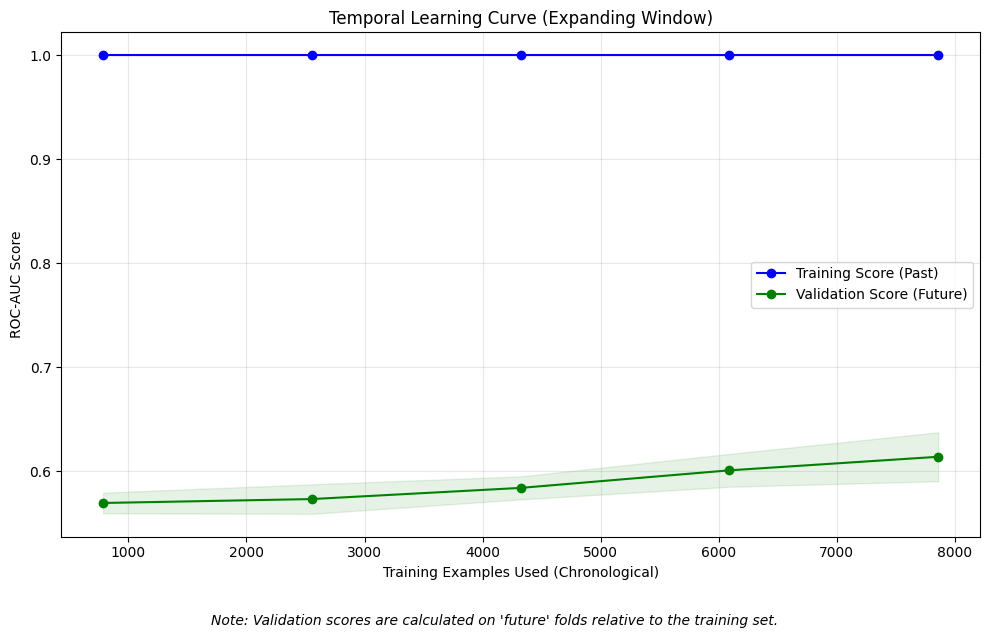

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def check_logreg_overfitting_temporal(model, X_train, y_train, X_test, y_test):
    """
    1. Calculates the Generalization Gap (Train vs Future Test).
    2. Generates a Time-Aware Learning Curve using TimeSeriesSplit.
       This prevents 'looking ahead' into the future during validation.
    """

    # --- PART 1: THE NUMBERS (Train vs Future Test) ---
    print("--- 1. GENERALIZATION GAP (2000-2013 vs 2013-2015) ---")

    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    gap = train_auc - test_auc

    print(f"Train AUC (Past):   {train_auc:.4f}")
    print(f"Test AUC (Future):  {test_auc:.4f}")
    print(f"Gap:                {gap:.4f}")

    if gap > 0.10:
        print("Verdict:   ⚠️ HIGH OVERFITTING (Memorizing the past, failing the future)")
    elif gap > 0.05:
        print("Verdict:   ⚠️ MODERATE OVERFITTING")
    else:
        print("Verdict:   ✅ GOOD TEMPORAL GENERALIZATION")

    # --- PART 2: THE VISUAL (Time-Series Learning Curve) ---
    print("\n--- 2. GENERATING TEMPORAL LEARNING CURVE ---")
    print("(Using 5-Split Expanding Window: Train on Year 0-N, Validate on Year N+1)")

    # CRITICAL CHANGE: Use TimeSeriesSplit instead of standard CV
    # This ensures we never train on future data to predict the past
    tscv = TimeSeriesSplit(n_splits=5)

    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=tscv,           # <--- The Fix: Enforce Time Order
        scoring='roc_auc',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=False      # <--- The Fix: Do not shuffle rows
    )

    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot Training Line
    plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score (Past)")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

    # Plot Validation Line
    plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score (Future)")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

    plt.title("Temporal Learning Curve (Expanding Window)")
    plt.xlabel("Training Examples Used (Chronological)")
    plt.ylabel("ROC-AUC Score")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

    # Add annotation explaining the split
    plt.figtext(0.5, -0.05, "Note: Validation scores are calculated on 'future' folds relative to the training set.",
                ha="center", fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# Note: X_train must be sorted by date for this to work correctly.
# Your notebook sorted df by 'start_year' before splitting, so X_train is already sorted.
check_logreg_overfitting_temporal(model, X_train, y_train, X_test, y_test)

Running Deep Dive Analysis on Baseline Model...


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/tmp/ipykernel_86941/325021978.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)


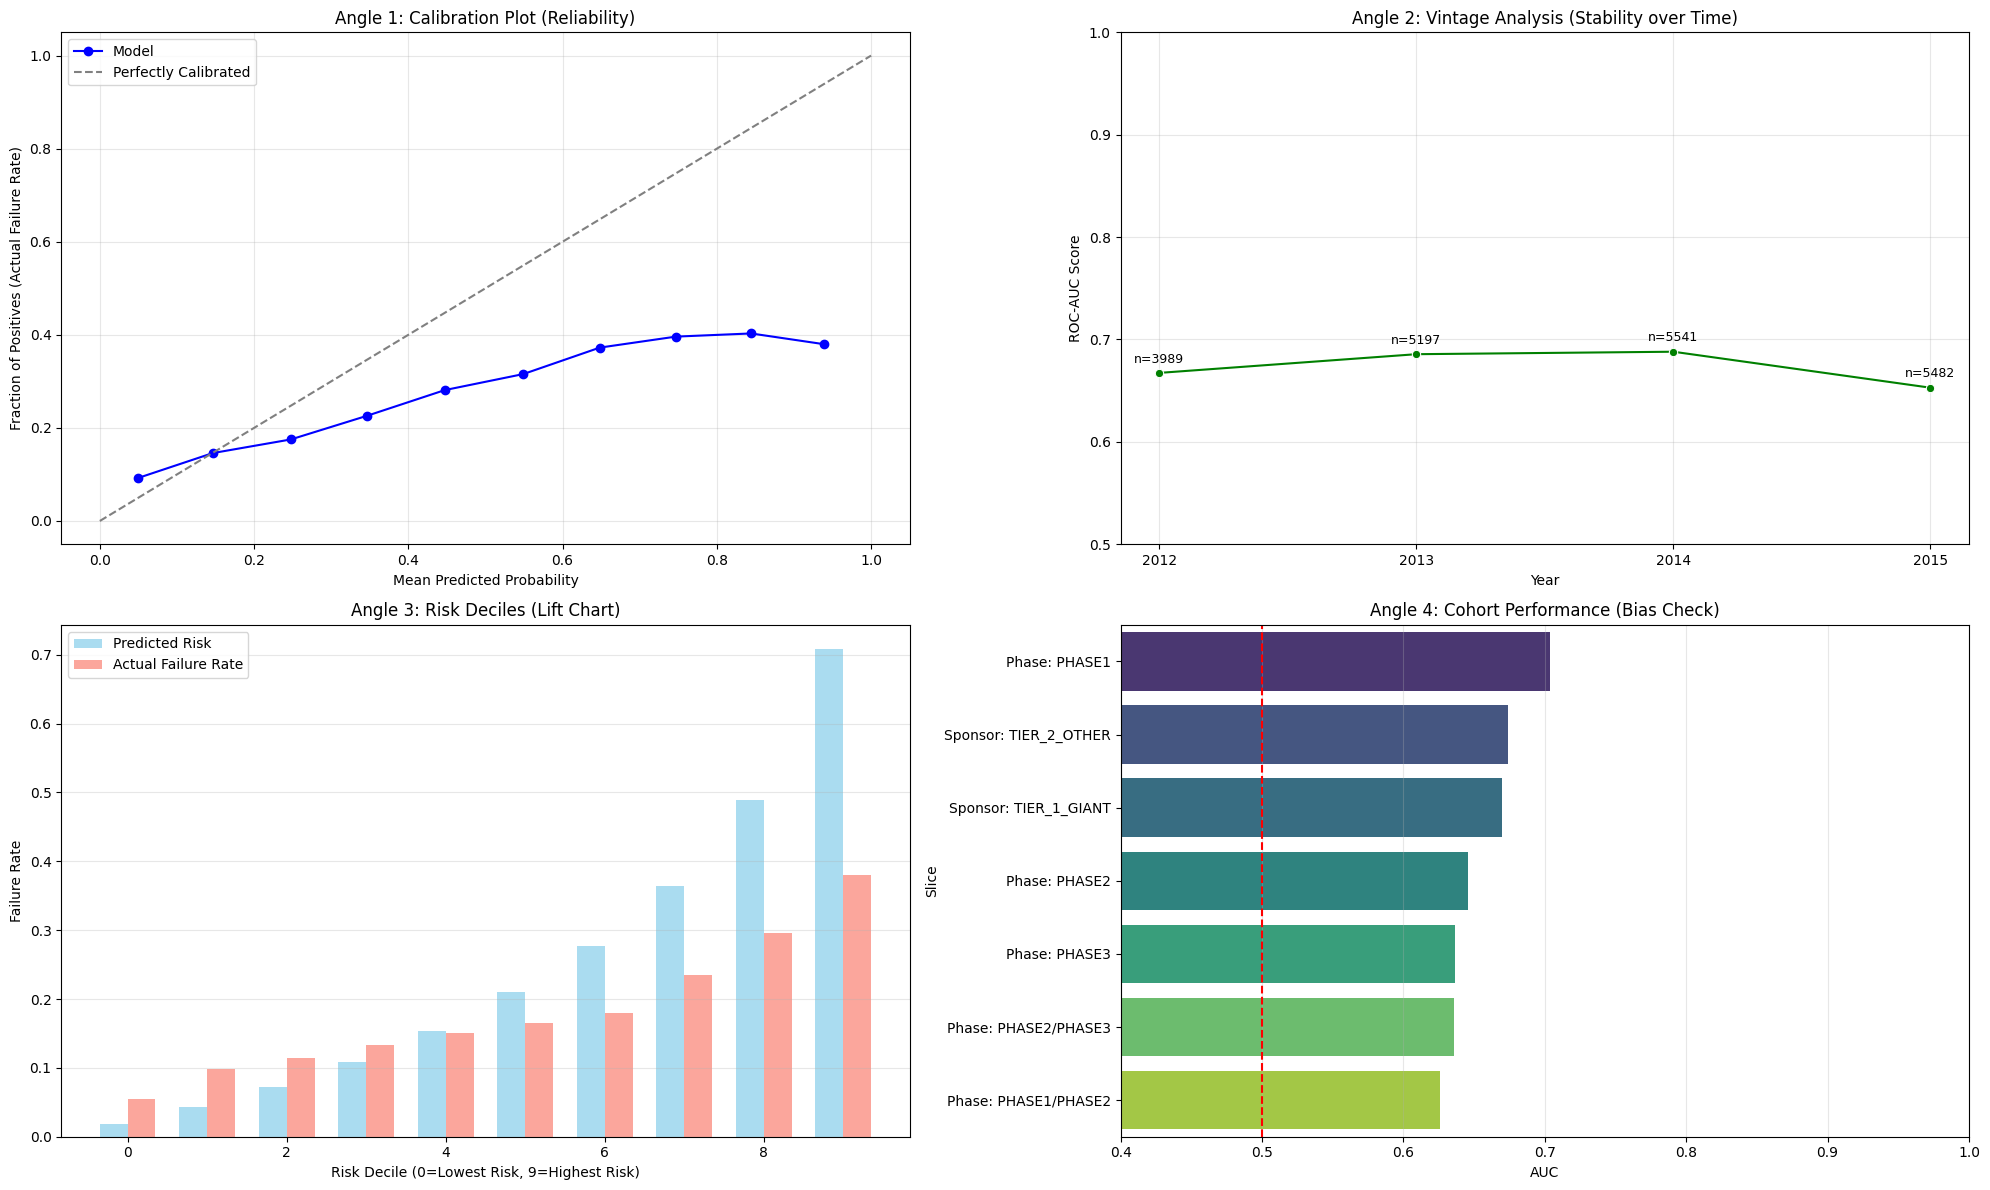

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def run_pro_analysis(model, X_test, y_test, raw_test_df):
    """
    Runs a 4-angle deep dive on model predictions.
    Requires:
    - model: Trained pipeline/model
    - X_test: Processed features (or raw if pipeline handles it)
    - y_test: Target labels
    - raw_test_df: The original dataframe for the test set (to extract Year/Phase/etc.)
    """

    # 1. Get Probabilities
    # Note: We take the probability of Class 1 (Failure)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Create a temporary analysis dataframe
    analysis_df = raw_test_df.copy().reset_index(drop=True)
    analysis_df['target'] = y_test.values
    analysis_df['prob_failure'] = y_probs

    # Setup Plotting Grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.3)

    # ==============================================================================
    # ANGLE 1: CALIBRATION CURVE (Reliability)
    # ==============================================================================
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    ax1 = axes[0, 0]
    ax1.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Fraction of Positives (Actual Failure Rate)')
    ax1.set_title('Angle 1: Calibration Plot (Reliability)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ==============================================================================
    # ANGLE 2: VINTAGE ANALYSIS (Temporal Stability)
    # ==============================================================================
    # Group by Start Year and calculate AUC per year
    vintage_stats = []
    years = sorted(analysis_df['start_year'].unique())

    for year in years:
        subset = analysis_df[analysis_df['start_year'] == year]
        if len(subset) > 0 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            count = len(subset)
            vintage_stats.append({'Year': int(year), 'AUC': auc, 'Count': count})

    vintage_df = pd.DataFrame(vintage_stats)

    ax2 = axes[0, 1]
    sns.lineplot(data=vintage_df, x='Year', y='AUC', marker='o', color='green', ax=ax2)
    ax2.set_ylim(0.5, 1.0)
    ax2.set_title('Angle 2: Vintage Analysis (Stability over Time)')
    ax2.set_ylabel('ROC-AUC Score')
    ax2.set_xticks(vintage_df['Year'])
    ax2.grid(True, alpha=0.3)

    # Add count labels
    for index, row in vintage_df.iterrows():
        ax2.text(row['Year'], row['AUC'] + 0.01, f"n={int(row['Count'])}", ha='center', fontsize=9)

    # ==============================================================================
    # ANGLE 3: RISK DECILE ANALYSIS (Business Impact)
    # ==============================================================================
    # Bin predictions into 10 buckets (Deciles)
    analysis_df['decile'] = pd.qcut(analysis_df['prob_failure'], 10, labels=False, duplicates='drop')

    decile_stats = analysis_df.groupby('decile').agg({
        'target': 'mean',          # Actual Failure Rate
        'prob_failure': 'mean'     # Predicted Failure Rate
    }).reset_index()

    ax3 = axes[1, 0]
    width = 0.35
    x = np.arange(len(decile_stats))

    ax3.bar(x - width/2, decile_stats['prob_failure'], width, label='Predicted Risk', color='skyblue', alpha=0.7)
    ax3.bar(x + width/2, decile_stats['target'], width, label='Actual Failure Rate', color='salmon', alpha=0.7)

    ax3.set_xlabel('Risk Decile (0=Lowest Risk, 9=Highest Risk)')
    ax3.set_ylabel('Failure Rate')
    ax3.set_title('Angle 3: Risk Deciles (Lift Chart)')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # ==============================================================================
    # ANGLE 4: COHORT SLICING (Phase & Sponsor)
    # ==============================================================================
    # Calculate AUC for specific slices
    slices = []

    # Slice by Phase
    for phase in analysis_df['phase'].unique():
        subset = analysis_df[analysis_df['phase'] == phase]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Phase: {phase}", 'AUC': auc})

    # Slice by Sponsor Tier
    for tier in analysis_df['sponsor_tier'].unique():
        subset = analysis_df[analysis_df['sponsor_tier'] == tier]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Sponsor: {tier}", 'AUC': auc})

    slice_df = pd.DataFrame(slices).sort_values('AUC', ascending=False)

    ax4 = axes[1, 1]
    sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)
    ax4.set_xlim(0.4, 1.0)
    ax4.set_title('Angle 4: Cohort Performance (Bias Check)')
    ax4.axvline(0.5, color='red', linestyle='--', label='Random')
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return analysis_df

# ---------------------------------------------------------
# EXECUTE ANALYSIS
# ---------------------------------------------------------
# Ensure we pass the raw test dataframe to get columns like 'start_year' and 'phase' back
# We use test_df (which you defined in cell 11 of your notebook)
print("Running Deep Dive Analysis on Baseline Model...")
results_df = run_pro_analysis(model, X_test, y_test, test_df)

In [ ]:
# 1. Instantiate the Preprocessor
preprocessor = get_pipeline()

# 2. Fit and Transform X_train
# CRITICAL FIX: Pass y_train here! TargetEncoder needs it.
print("Running preprocessor... this might take a moment due to SVD...")
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# --- FIX FOR SPARSE MATRICES ---
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# 3. Get Feature Names
feature_names = preprocessor.get_feature_names_out()

# 4. Convert to DataFrame for Easy Viewing
df_transformed = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index
)

# --- INSPECTION REPORT ---
print(f"\nOriginal Shape: {X_train.shape}")
print(f"Transformed Shape: {df_transformed.shape}")
print("-" * 50)

# 5. Inspect SVD Columns
svd_cols = [col for col in df_transformed.columns if 'svd' in col.lower()]
if svd_cols:
    print(f"\n✅ Found {len(svd_cols)} Text SVD Features")
    print(df_transformed[svd_cols[:5]].head(3))
else:
    print("\n❌ Could not identify SVD columns by name.")

# 6. Show Head
print("\nFirst 5 rows of transformed data:")
try:
    display(df_transformed.head())
except:
    print(df_transformed.head())

Running preprocessor... this might take a moment due to SVD...


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['center', 'first', 'in', 'multi'] not in stop_words.
  warnings.warn(



Original Shape: (47154, 131)
Transformed Shape: (47154, 232)
--------------------------------------------------

✅ Found 50 Text SVD Features
   truncatedsvd0  truncatedsvd1  truncatedsvd2  truncatedsvd3  truncatedsvd4
0       0.415361       0.045157      -0.113047      -0.239244       0.126020
1       0.197017       0.396816      -0.069808       0.222941      -0.272823
2       0.109518       0.264110       0.013134      -0.060402       0.177003

First 5 rows of transformed data:


,competition_niche,competition_broad,num_primary_endpoints,number_of_arms,criteria_len_log,start_year,phase_ordinal,is_international_1,covid_exposure_0,healthy_volunteers_No,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,-2.264412,-3.057399,-0.457916,-0.011309,-0.162765,-2.290953,0.5,0.0,1.0,0.0,...,0.913526,-0.911506,-0.143758,1.442989,-1.068215,-0.858067,-1.372770,0.172274,-0.484605,0.537201
1,0.053851,-0.245207,-0.457916,-0.011309,1.066840,-2.290953,0.5,1.0,1.0,0.0,...,-1.240272,-0.630186,0.004333,-0.158138,0.587958,0.989771,1.204132,0.131291,-0.799579,0.966378
2,0.053851,-0.245207,-0.457916,-1.223439,0.591851,-2.290953,0.5,1.0,1.0,0.0,...,-0.298372,0.421366,0.107073,-0.457955,-0.321163,0.969145,2.280956,0.958163,0.922529,0.939318
3,0.053851,-0.245207,-0.457916,-0.011309,0.600111,-2.290953,0.5,0.0,1.0,0.0,...,-1.805191,1.251789,-1.183439,1.648976,0.628731,1.215972,-0.966629,-0.734873,-1.449258,-0.765672
4,-0.732163,-1.720107,2.428461,0.848712,0.418083,-2.290953,0.0,0.0,1.0,0.0,...,0.123007,0.162064,-0.481296,-1.514150,0.788957,-1.170901,0.262319,-0.014728,-0.924124,-1.767538


In [ ]:
import pandas as pd
import numpy as np

# 1. Load Data (Assuming 'df' is your loaded dataframe from the loader)
# If df is not in memory, uncomment:
# from src.data_loader_tx import ClinicalTrialLoader
# loader = ClinicalTrialLoader(data_path='data/')
# df = loader.load_and_clean()
# df = loader.add_features(df)

print("=== 1. PHASE MAPPING AUDIT ===")
# Check how raw phases map to the ordinal feature
phase_check = df[['phase', 'phase_ordinal']].drop_duplicates().sort_values('phase_ordinal')
print(phase_check)

print("\n=== 2. FEATURE DISTRIBUTION AUDIT (Pre-Scaling) ===")
# Check stats of numerical columns to see their natural range
num_cols = ['competition_broad', 'num_primary_endpoints', 'criteria_len_log', 'start_year']
print(df[num_cols].describe().loc[['min', 'max', 'mean', 'std']])

print("\n=== 3. MISSING VALUES CHECK ===")
# XGBoost handles NaNs automatically, but good to know
missing = df.isnull().sum()
print(missing[missing > 0])

=== 1. PHASE MAPPING AUDIT ===
            phase  phase_ordinal
4          PHASE1              1
0          PHASE2              2
3   PHASE1/PHASE2              2
7          PHASE3              3
25  PHASE2/PHASE3              3

=== 2. FEATURE DISTRIBUTION AUDIT (Pre-Scaling) ===
      competition_broad  num_primary_endpoints  criteria_len_log   start_year
min            1.000000               1.000000          1.386294  2000.000000
max         3215.000000             118.000000          9.805709  2015.000000
mean        1387.253834               1.786248          7.316935  2008.995606
std         1071.951975               2.677579          0.924245     4.009484

=== 3. MISSING VALUES CHECK ===
start_date_type       52559
number_of_arms         8683
why_stopped           58783
allocation            16563
intervention_model     1881
primary_purpose        1919
masking                1292
txt_criteria             19
dtype: int64
